In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

# Numpy version >= 1.17.4

points_filename = r"test_points.txt" # 'r' means \t is '\t', not tab
images_filename = r"mnist-test"
labels_filename = r"mnist-test-labels"

# Helper functions:
def load_mnist_images(filename, dtype='uint8'):
    with open(filename, 'rb') as f:
        f.read(4)
        n_samples = int.from_bytes(f.read(4), byteorder='big')
        n_rows = int.from_bytes(f.read(4), byteorder='big')
        n_cols = int.from_bytes(f.read(4), byteorder='big')
        images = np.fromfile(f, dtype=np.uint8)

    images = images.reshape((n_samples, n_rows, n_cols))
    images = np.ascontiguousarray(images, dtype=dtype)
    return images


def load_mnist_labels(filename, dtype='uint8'):
    labels = np.fromfile(filename, dtype=np.uint8, offset=8)
    return np.ascontiguousarray(labels, dtype=dtype)


def plot_cluster(dataset, k, cluster_idx, labels=None):
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
    hatches = ['o', 'x', '+', '*', '.', '-', 'O', '|']
    n_samples, dim = dataset.shape
    assert dim == 2 and k <= len(colors), 'Too many clusters.'

    handles = []
    for i in range(k):
        selected = cluster_idx == i
        x = dataset[selected, 0]
        y = dataset[selected, 1]
        handles.append(plt.scatter(x, y, marker=hatches[i], color=colors[i]))

    if labels is not None:
        assert len(labels) == len(handles)
        plt.legend(handles, labels)


def pca(dataset, topk):
    n_samples, n_dims = dataset.shape

    dataset -= np.mean(dataset, axis=0)
    covariance = dataset.T @ dataset / (n_samples - 1)
    eig_vals, eig = np.linalg.eig(covariance)

    topk_idx = np.argsort(eig_vals, kind='stable')[::-1][:topk]
    topk_eigs = eig[:, topk_idx]
    reconstructed = dataset @ topk_eigs
    return reconstructed

a_image shape: (1135, 28, 28), b_image shape: (1028, 28, 28)


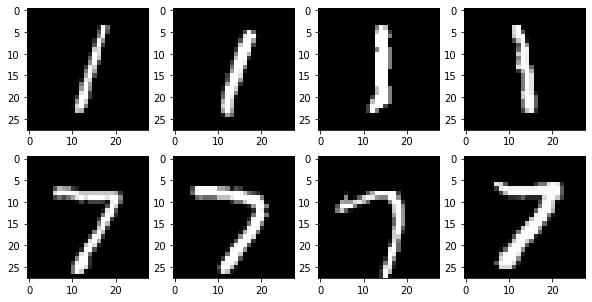

In [2]:
# load data
raw_images = load_mnist_images(images_filename, dtype='float32')
raw_labels = load_mnist_labels(labels_filename, dtype='uint8')

a_image = raw_images[raw_labels == 1]  # Handwritten number ‘1’
b_image = raw_images[raw_labels == 7]  # Handwritten number ‘7’

print(f'a_image shape: {a_image.shape}, b_image shape: {b_image.shape}')

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

for i in range(axs.shape[1]):
    axs[0][i].imshow(a_image[i], cmap='gray')

for i in range(axs.shape[1]):
    axs[1][i].imshow(b_image[i], cmap='gray')


plt.show()

Reduced `dataset` has size: (2163, 2)


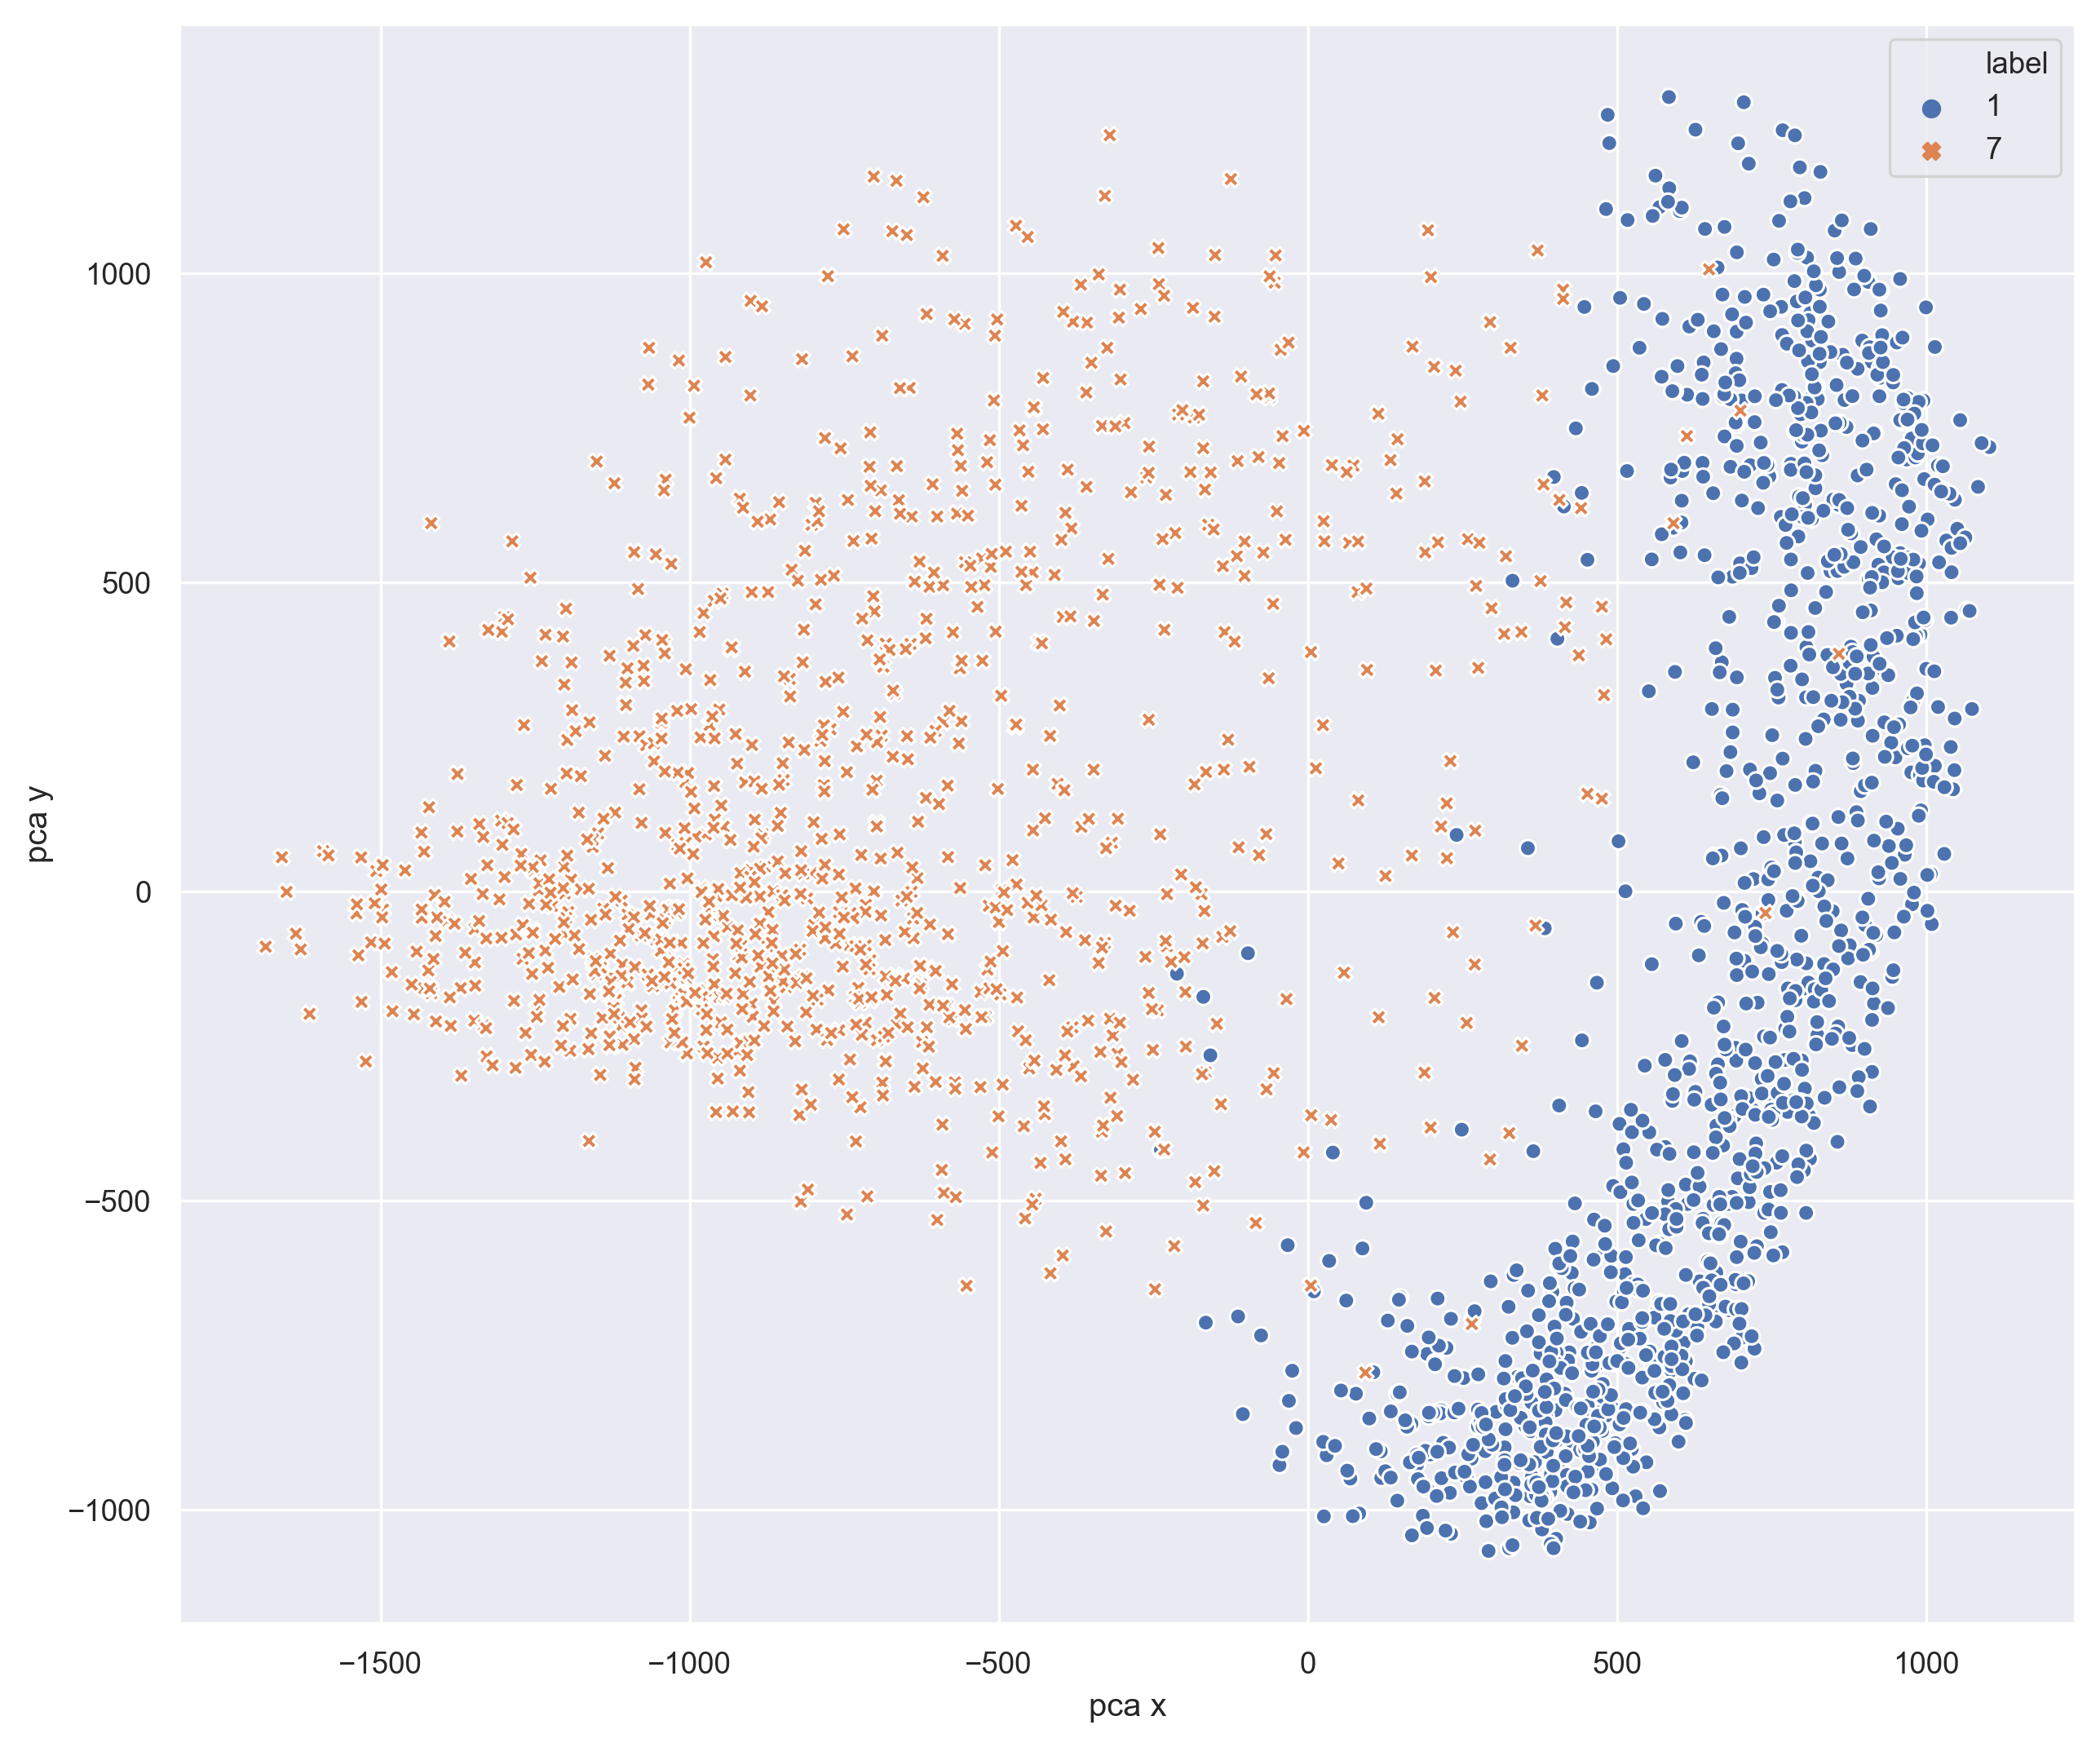

In [3]:
    sns.set()
    sns.set_context('paper')

    # reduce dimensions 784 to 2
    raw_data = np.concatenate([a_image, b_image]).reshape((-1, 784))
    K = 2
    dataset = pca(raw_data, K)

    a_index = range(len(a_image))
    b_index = range(len(a_image), len(raw_data))

    print(f'Reduced `dataset` has size: {dataset.shape}')

    data = pd.DataFrame({
        'pca x': dataset[:, 0],
        'pca y': dataset[:, 1],
        'label': np.concatenate([np.repeat(1, len(a_image)), np.repeat(7, len(b_image))]),
    })

    plt.figure(figsize=(10,10), dpi= 300)
    ax = sns.scatterplot(data=data, x='pca x', y='pca y', hue='label', style='label', palette='deep')
    ax.set_aspect('equal')

    plt.show()

In [4]:
# ================= k-means =================
# step 1:
n_samples, dim = dataset.shape
centroids = np.zeros((K, dim), dtype='float32')
cluster_idx = np.zeros(n_samples, dtype=np.intp)
sample_dist = np.zeros(n_samples, dtype='float32')

tmp = np.empty((n_samples, K, dim), dtype='float32')

print(f'1. `centroids` has size of {centroids.shape}.')
print(f'2. `cluster_idx` has size of {cluster_idx.shape}.')
print(f'3. `sample_dist` has size of {sample_dist.shape}.')
print(f'4. `tmp` has size of {tmp.shape}.')

1. `centroids` has size of (2, 2).
2. `cluster_idx` has size of (2163,).
3. `sample_dist` has size of (2163,).
4. `tmp` has size of (2163, 2, 2).


[[0. 0.]
 [0. 0.]]
[[-1412.2982       -5.5095825]
 [    0.            0.       ]]
(2163, 2)
[[-1412.2982       -5.5095825]
 [  705.0199     1276.7322   ]]


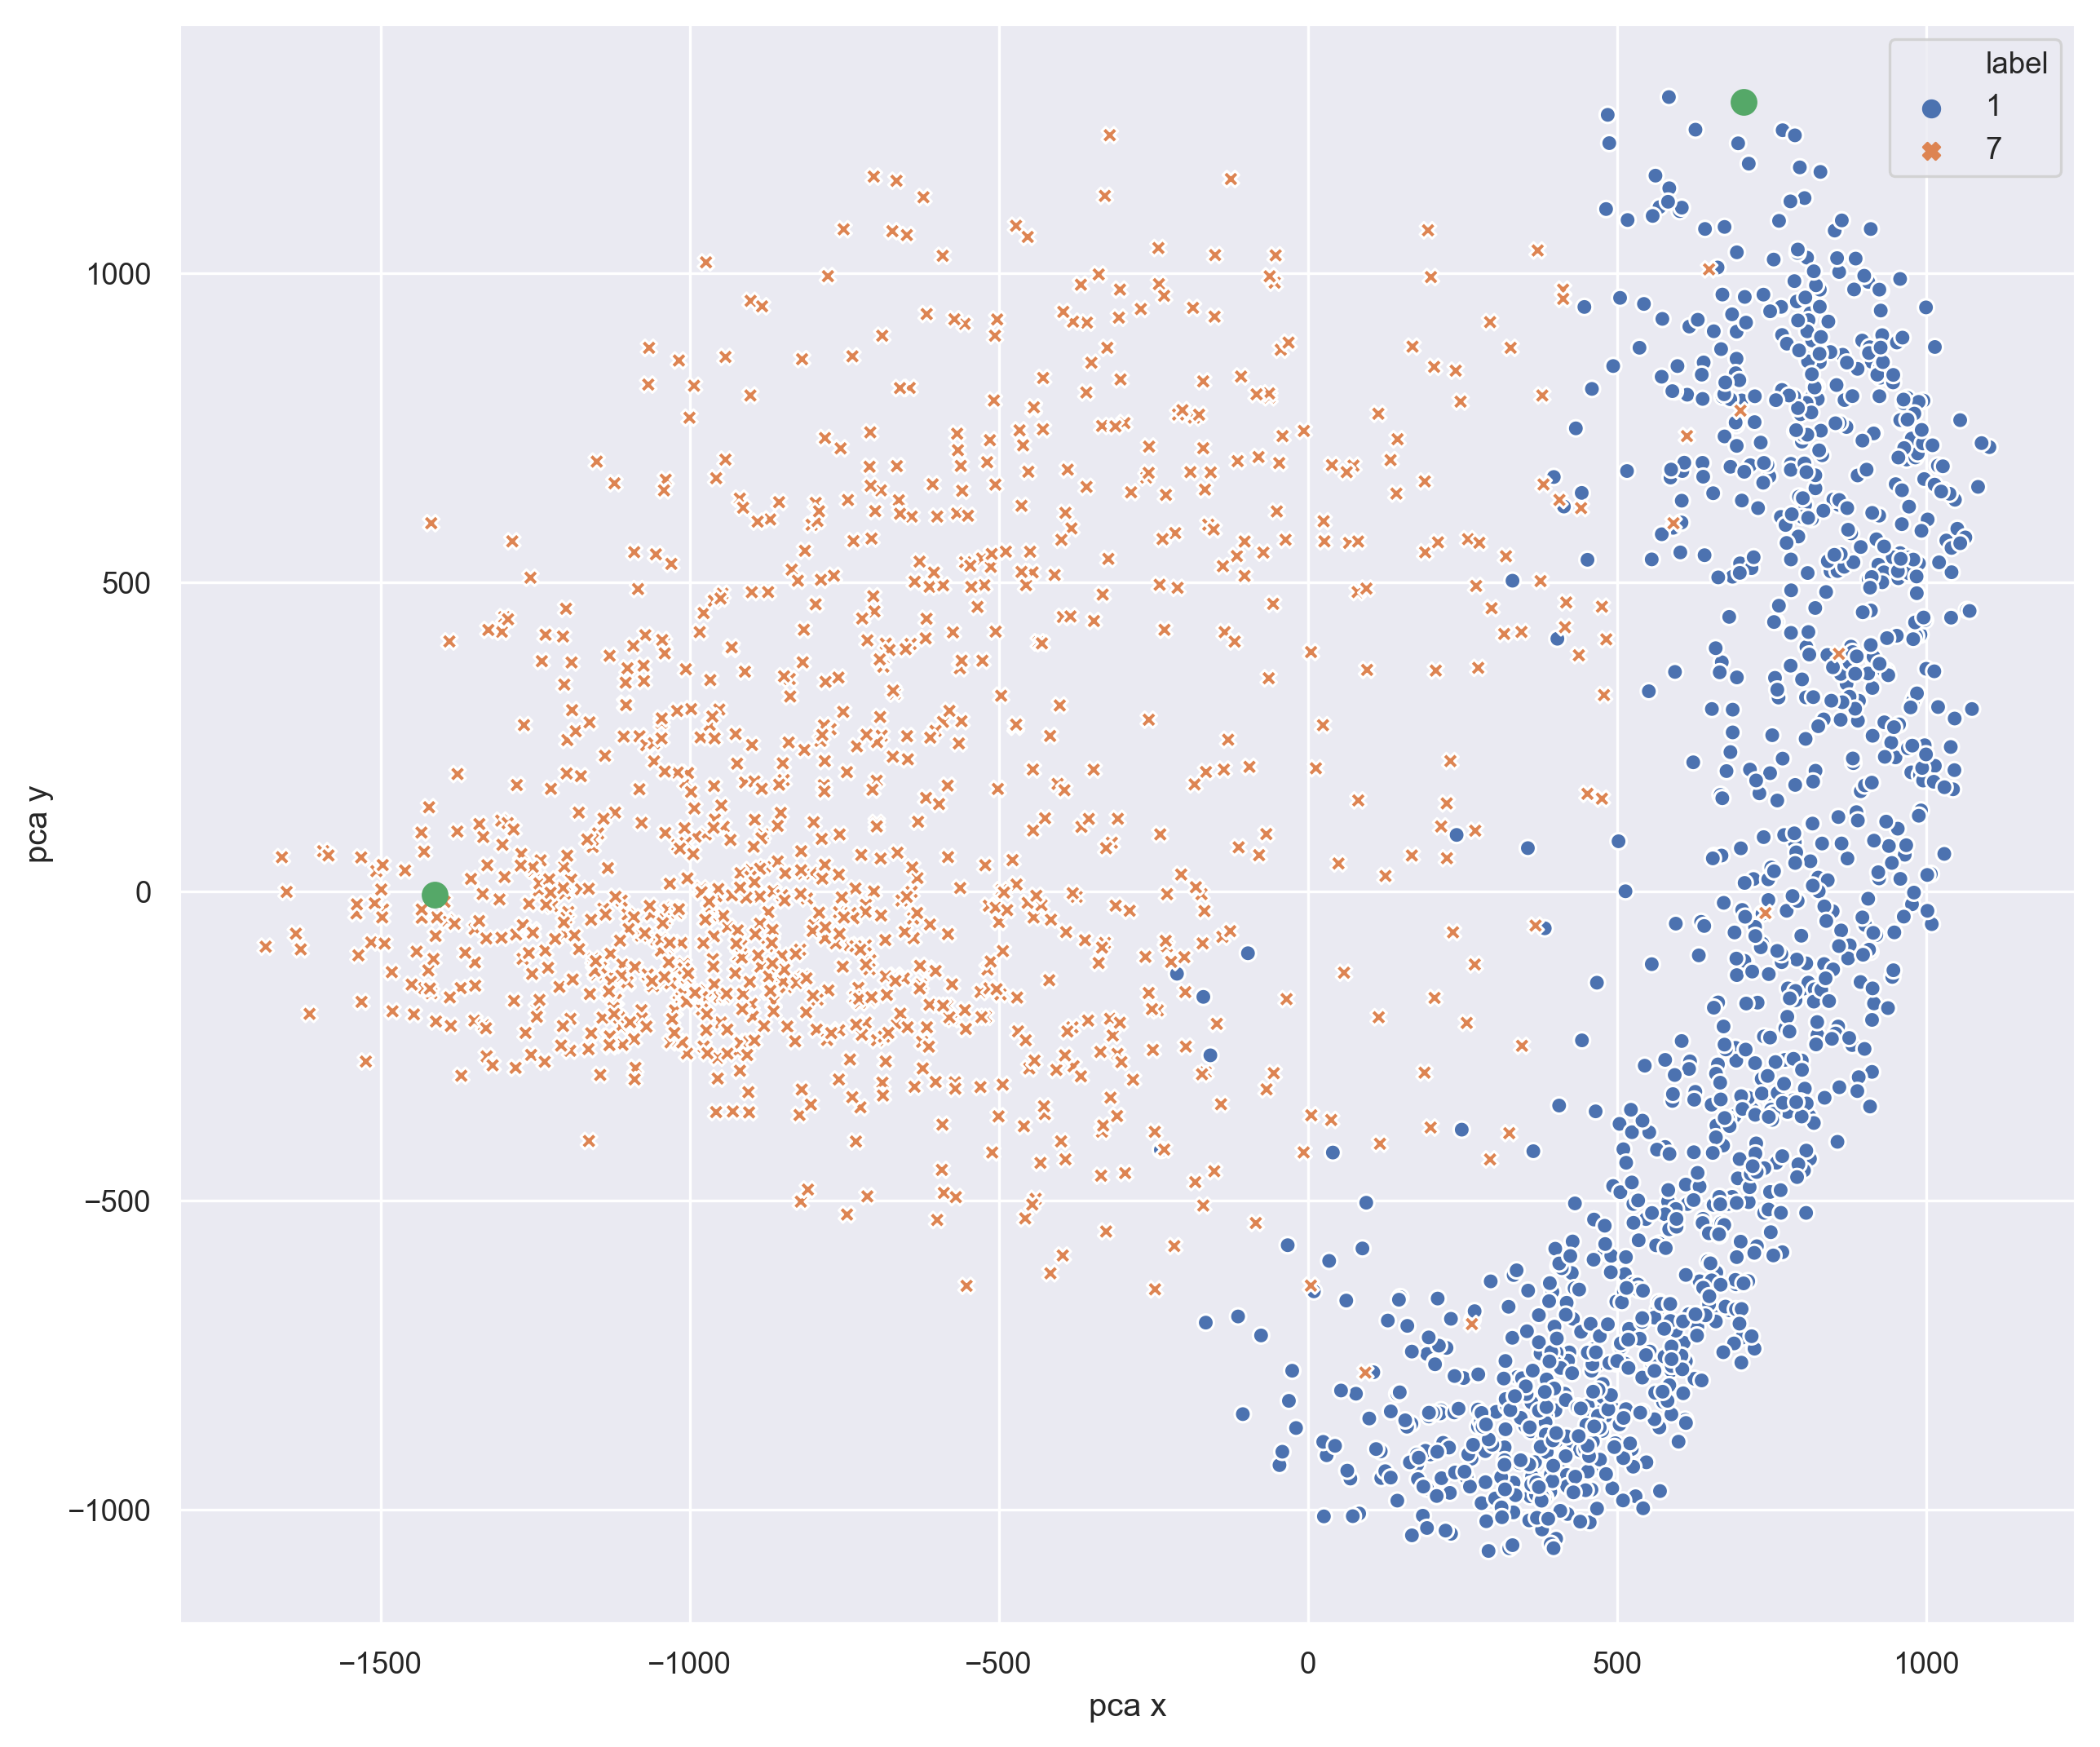

In [5]:
# step 2: use k-means++ method to initialize centroids.
print(centroids)
c_index = np.random.choice(range(len(dataset)), 1)[0]
centroids[0] = dataset[c_index]
print(centroids)

cdist = np.zeros((n_samples, K), dtype='float32')
for i in range(1, K):
    cdist = dataset[:, None, :] - centroids # Using broadcast mechanism
    cdist = cdist ** 2 # 逐元素平方
    cdist = np.sum(cdist, axis=-1) # 求x和y方向的差值平方和
    print(cdist.shape)
    max_idx = np.argmax(np.min(cdist, axis=-1))
    centroids[i, :] = dataset[max_idx, :]

print(centroids)
plt.figure(figsize=(10,10), dpi= 300)
ax = sns.scatterplot(data=data, x='pca x', y='pca y', hue='label', style='label', palette='deep')
ax.set_aspect('equal')
ax.scatter(centroids[:, 0], centroids[:, 1], color='g', s=50)

plt.show()

In [9]:
a = np.array([[1,2],[4,5],[7,8]]) # (3,2)
# [:,None,:]
# 3,1,2 -> 3,2,2 广播第二维
# 3,1,2 - 2,2 = 3,2,2 横向做差
# [:,:,None]
# 3,2,1 -> 3,2,2 广播最后一维
# 3,2,1 - 2,2 = 3,2,2 纵向做差
a[:,None,:]-np.array([[1,2],[2,3]])

array([[[ 0,  0],
        [-1, -1]],

       [[ 3,  3],
        [ 2,  2]],

       [[ 6,  6],
        [ 5,  5]]])

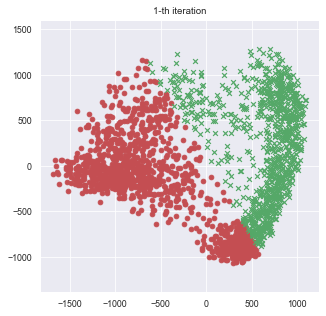

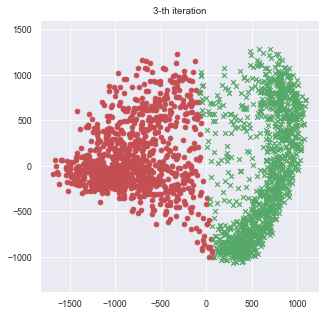

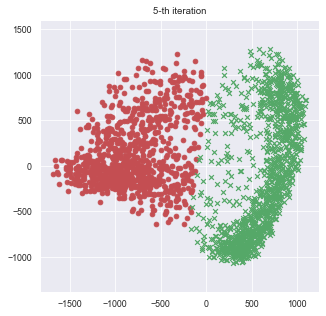

In [7]:
# step 3: computing distances and updating centroids
max_iters = 20
dist = np.zeros((n_samples, K), dtype='float32')
for i in range(max_iters):
    # compute distance
    dist = dataset[:, None, :] - centroids # Broadcast to (n, k, dim)
    dist = np.square(dist) 
    dist = np.sum(dist, axis=-1) # (n, k, dim) -> (n, k)

    min_idx = np.argmin(dist, axis=-1) # (n, k) -> (n,)
    min_dist = dist[range(n_samples), min_idx] # https://numpy.org/doc/1.19/reference/arrays.indexing.html#integer-array-indexing
    changed = cluster_idx != min_idx
    if not changed.any():
        break

    # update centroids here.
    cluster_idx[changed] = min_idx[changed] # https://numpy.org/doc/1.19/reference/arrays.indexing.html#boolean-array-indexing
    sample_dist[changed] = min_dist[changed]
    for j in range(K):
        centroids[j, :] = np.mean(dataset[cluster_idx == j], axis=0)
        
    if i % 2 == 0:
        plt.figure(figsize=(5, 5))
        plt.axis('equal')
        plt.title(f'{i+1}-th iteration')
        plot_cluster(dataset, K, cluster_idx)

plt.show()

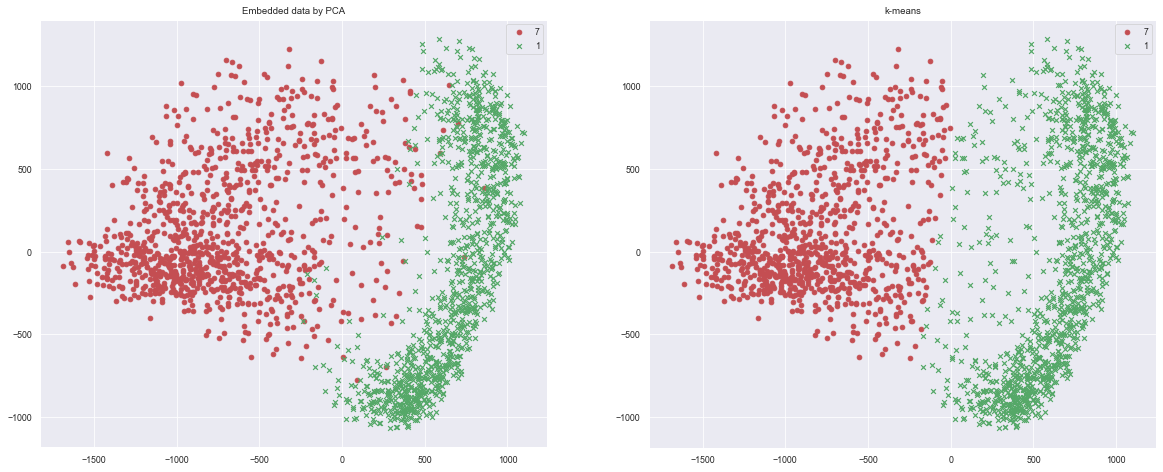

In [8]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(1, 2, 1)
ax.set_aspect('equal')
ax.set_title('Embedded data by PCA')
b_out = dataset[b_index, :]
a_out = dataset[a_index, :]
p2 = ax.scatter(b_out[:, 0], b_out[:, 1], c='r', marker='o')
p1 = ax.scatter(a_out[:, 0], a_out[:, 1], c='g', marker='x')
plt.legend([p2, p1], ['7', '1'])

ax = plt.subplot(1, 2, 2)
ax.set_aspect('equal')
ax.set_title('k-means')
plot_cluster(dataset, K, cluster_idx, ['7', '1'])
plt.show()